In [4]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.7 MB/s eta 0:00:00a 0:00:01


In [5]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
import numpy as np
import tensorflow as tf
import deepxde as dde
print(os.getenv('DDE_BACKEND'))

2024-04-08 07:53:27.153818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 07:53:27.153933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 07:53:27.329043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



tensorflow


In [7]:
dde.config.set_default_float('float32')

Set the default float type to float32


In [8]:
spacedomain = dde.geometry.Rectangle([0, -np.pi], [np.pi, np.pi])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(spacedomain, timedomain)

In [9]:
def pde(x, u):
  du_t = dde.grad.jacobian(u, x, i=0, j=2)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)
  du_yy = dde.grad.hessian(u, x, i=1, j=1)
  x, y, t = x[:, 0:1], x[:, 1:2], x[:, 2:3]
  return du_t - 19/10 * (du_xx + du_yy) - L * tf.exp((-3 * t) / 5) * tf.sin((23 * x) / 10) - (189 * tf.exp((-3 * t) / 5) * tf.cos((3 * y) / 5)) / 1250

In [11]:
def func0(x):
  return (17 * np.sin((23 * x[:, 0:1]) / 10)) / 10 + (9 * np.cos((3 * x[:, 1:2]) / 5)) / 5 + 1

def func1(x):
  return 1 + (9 * np.exp((-3 * x[:, 2:3]) / 5) * np.cos((3 * x[:, 1:2]) / 5)) / 5

def func2(x):
  return (391 * np.sqrt(5/8 - np.sqrt(5)/8) * np.exp((-3 * x[:, 2:3]) / 5)) / 100

def func3(x):
  return -(27 * np.sqrt(np.sqrt(5)/8 + 5/8) * np.exp((-3 * x[:, 2:3]) / 5)) / 25 #sign

def func4(x):
  return -(27 * np.sqrt(np.sqrt(5)/8 + 5/8) * np.exp((-3 * x[:, 2:3]) / 5)) / 25

In [12]:
def boundary_left(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], np.pi)

def boundary_bottom(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[1], -np.pi)

def boundary_top(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[1], np.pi)

In [13]:
bc_left = dde.icbc.DirichletBC(geomtime, func1, boundary_left)
bc_right = dde.icbc.NeumannBC(geomtime, func2, boundary_right)
bc_bottom = dde.icbc.NeumannBC(geomtime, func3, boundary_bottom) #sign
bc_top = dde.icbc.NeumannBC(geomtime, func4, boundary_top)
ic = dde.icbc.IC(geomtime, func0, lambda _, on_initial: on_initial)

In [14]:
obs_data = np.load("/kaggle/input/var-30/var-30.npz")
observe_x = obs_data["xyt"]
observe_u = dde.icbc.PointSetBC(observe_x, obs_data["u"])

In [15]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right, bc_bottom, bc_top, ic, observe_u],
    num_domain=10000,
    num_boundary=1000,
    num_initial=1000,
    anchors=observe_x,
    num_test=3000,
)

In [32]:
L = dde.Variable(0.0)
resample = dde.callbacks.PDEPointResampler(period=100, bc_points=False and dde.backend.backend_name == 'tensorflow')
variable = dde.callbacks.VariableValue(L, period=1000)
callbacks = [resample, variable]
layer_size = [3] + [30] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [33]:
model1 = dde.Model(data, net)

In [34]:
model1.compile("adam", lr=0.001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model1.train(iterations=15000, display_every=500, callbacks=callbacks)

Compiling model...
'compile' took 0.003150 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.51e-01, 3.86e+00, 2.44e+00, 1.60e-01, 7.96e-01, 6.82e+00, 3.44e+00]    [1.98e-01, 3.86e+00, 2.44e+00, 1.60e-01, 7.96e-01, 6.82e+00, 3.44e+00]    []  
0 [0.00e+00]


W0000 00:00:1712523979.627424      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500       [2.31e-01, 4.77e-02, 4.11e-02, 1.15e-02, 1.42e-02, 3.84e-01, 4.21e-01]    [1.08e+00, 4.77e-02, 4.11e-02, 1.15e-02, 1.42e-02, 3.84e-01, 4.21e-01]    []  
1000      [1.65e-01, 2.52e-02, 5.13e-02, 6.41e-03, 6.79e-03, 5.57e-02, 3.53e-01]    [1.03e+00, 2.52e-02, 5.13e-02, 6.41e-03, 6.79e-03, 5.57e-02, 3.53e-01]    []  
1000 [9.63e-01]
1500      [1.54e-01, 1.65e-02, 4.54e-02, 5.34e-03, 5.78e-03, 3.34e-02, 3.16e-01]    [9.65e-01, 1.65e-02, 4.54e-02, 5.34e-03, 5.78e-03, 3.34e-02, 3.16e-01]    []  
2000      [1.41e-01, 1.62e-02, 4.39e-02, 4.93e-03, 5.41e-03, 1.96e-02, 2.93e-01]    [9.11e-01, 1.62e-02, 4.39e-02, 4.93e-03, 5.41e-03, 1.96e-02, 2.93e-01]    []  
2000 [1.73e+00]
2500      [1.29e-01, 1.36e-02, 3.95e-02, 4.44e-03, 5.11e-03, 2.19e-02, 2.64e-01]    [8.74e-01, 1.36e-02, 3.95e-02, 4.44e-03, 5.11e-03, 2.19e-02, 2.64e-01]    []  
3000      [1.14e-01, 1.74e-02, 3.67e-02, 4.56e-03, 5.38e-03, 5.74e-03, 2.55e-01]    [7.97e-01, 1.74e-02, 3.67e-02, 4.56e-03, 5.38e-03, 5.74e-03, 2.55e-01

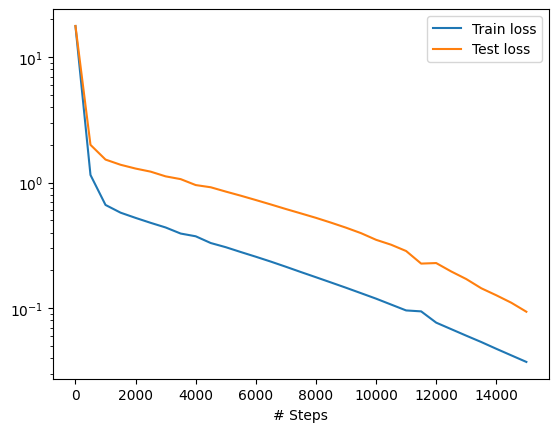

In [35]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [37]:
model1.compile("adam", lr=0.0001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model1.train(iterations=50000, display_every=1000, callbacks=callbacks)

Compiling model...
'compile' took 0.004292 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
15000     [8.88e-03, 1.12e-03, 3.86e-03, 5.13e-03, 5.24e-03, 6.14e-04, 1.24e-02]    [6.52e-02, 1.12e-03, 3.86e-03, 5.13e-03, 5.24e-03, 6.14e-04, 1.24e-02]    []  
15000 [1.26e+01]


W0000 00:00:1712524723.498353      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16000     [8.48e-03, 1.04e-03, 3.69e-03, 5.13e-03, 5.24e-03, 5.85e-04, 1.17e-02]    [6.25e-02, 1.04e-03, 3.69e-03, 5.13e-03, 5.24e-03, 5.85e-04, 1.17e-02]    []  
16000 [1.27e+01]
17000     [7.86e-03, 9.97e-04, 3.55e-03, 5.14e-03, 5.22e-03, 5.50e-04, 1.10e-02]    [5.85e-02, 9.97e-04, 3.55e-03, 5.14e-03, 5.22e-03, 5.50e-04, 1.10e-02]    []  
17000 [1.28e+01]
18000     [7.12e-03, 9.98e-04, 3.54e-03, 5.15e-03, 5.20e-03, 4.29e-04, 1.04e-02]    [5.37e-02, 9.98e-04, 3.54e-03, 5.15e-03, 5.20e-03, 4.29e-04, 1.04e-02]    []  
18000 [1.29e+01]
19000     [6.76e-03, 9.15e-04, 3.33e-03, 5.17e-03, 5.19e-03, 4.76e-04, 9.70e-03]    [5.14e-02, 9.15e-04, 3.33e-03, 5.17e-03, 5.19e-03, 4.76e-04, 9.70e-03]    []  
19000 [1.30e+01]
20000     [6.49e-03, 8.39e-04, 3.14e-03, 5.18e-03, 5.19e-03, 5.31e-04, 9.00e-03]    [4.93e-02, 8.39e-04, 3.14e-03, 5.18e-03, 5.19e-03, 5.31e-04, 9.00e-03]    []  
20000 [1.31e+01]
21000     [6.15e-03, 8.03e-04, 3.01e-03, 5.20e-03, 5.19e-03, 5.56e-04, 8.36e-03]    [4.67e-02, 8.03e

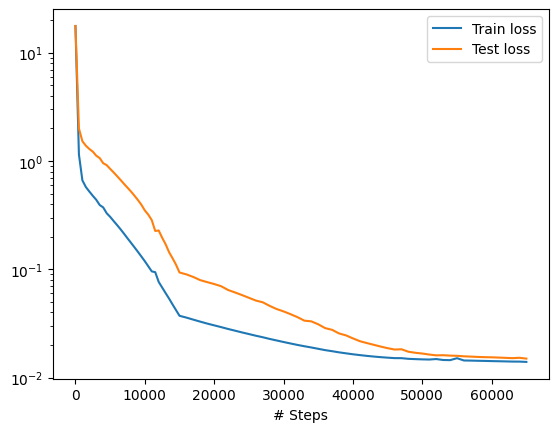

In [38]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [39]:
model1.compile("adam", lr=0.00001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model1.train(iterations=50000, display_every=1000, callbacks=callbacks)

Compiling model...
'compile' took 0.009804 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
65000     [3.99e-04, 5.71e-04, 2.21e-03, 5.47e-03, 5.08e-03, 2.02e-05, 2.13e-04]    [1.43e-03, 5.71e-04, 2.21e-03, 5.47e-03, 5.08e-03, 2.02e-05, 2.13e-04]    []  
65000 [1.58e+01]


W0000 00:00:1712526480.916464      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66000     [4.03e-04, 5.70e-04, 2.20e-03, 5.46e-03, 5.07e-03, 2.01e-05, 2.11e-04]    [1.42e-03, 5.70e-04, 2.20e-03, 5.46e-03, 5.07e-03, 2.01e-05, 2.11e-04]    []  
66000 [1.58e+01]
67000     [4.01e-04, 5.80e-04, 2.21e-03, 5.44e-03, 5.05e-03, 1.95e-05, 2.10e-04]    [1.39e-03, 5.80e-04, 2.21e-03, 5.44e-03, 5.05e-03, 1.95e-05, 2.10e-04]    []  
67000 [1.58e+01]
68000     [4.00e-04, 5.87e-04, 2.21e-03, 5.41e-03, 5.02e-03, 1.86e-05, 2.10e-04]    [1.37e-03, 5.87e-04, 2.21e-03, 5.41e-03, 5.02e-03, 1.86e-05, 2.10e-04]    []  
68000 [1.58e+01]
69000     [3.98e-04, 5.90e-04, 2.21e-03, 5.39e-03, 4.99e-03, 1.79e-05, 2.08e-04]    [1.35e-03, 5.90e-04, 2.21e-03, 5.39e-03, 4.99e-03, 1.79e-05, 2.08e-04]    []  
69000 [1.58e+01]
70000     [3.90e-04, 5.99e-04, 2.21e-03, 5.36e-03, 4.96e-03, 1.72e-05, 2.07e-04]    [1.32e-03, 5.99e-04, 2.21e-03, 5.36e-03, 4.96e-03, 1.72e-05, 2.07e-04]    []  
70000 [1.58e+01]
71000     [3.98e-04, 5.97e-04, 2.21e-03, 5.34e-03, 4.94e-03, 1.67e-05, 2.05e-04]    [1.31e-03, 5.97e

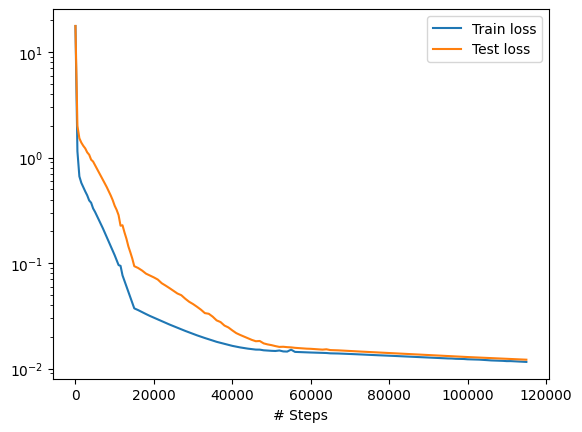

In [40]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [13]:
L = dde.Variable(10.0)
resample = dde.callbacks.PDEPointResampler(period=100, bc_points=False and dde.backend.backend_name == 'tensorflow')
variable = dde.callbacks.VariableValue(L, period=1000)
callbacks = [resample, variable]
layer_size = [3] + [30] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model2 = dde.Model(data, net)

In [15]:
model2.compile("adam", lr=0.001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model2.train(iterations=10000, display_every=500, callbacks=callbacks)

Compiling model...
'compile' took 0.003401 s

Training model...



I0000 00:00:1712519171.716052      34 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.62e+01, 3.86e+00, 2.44e+00, 1.60e-01, 7.96e-01, 6.82e+00, 3.44e+00]    [2.66e+01, 3.86e+00, 2.44e+00, 1.60e-01, 7.96e-01, 6.82e+00, 3.44e+00]    []  
0 [1.00e+01]


W0000 00:00:1712519177.209228      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500       [9.89e-02, 1.94e-02, 9.27e-02, 1.17e-02, 1.04e-02, 1.70e-01, 9.33e-02]    [1.64e-01, 1.94e-02, 9.27e-02, 1.17e-02, 1.04e-02, 1.70e-01, 9.33e-02]    []  
1000      [5.62e-02, 9.83e-03, 1.08e-02, 5.12e-03, 5.53e-03, 7.49e-02, 6.77e-02]    [2.29e-01, 9.83e-03, 1.08e-02, 5.12e-03, 5.53e-03, 7.49e-02, 6.77e-02]    []  
1000 [9.90e+00]
1500      [8.64e-02, 5.28e-03, 3.70e-03, 4.28e-03, 4.80e-03, 5.24e-02, 5.22e-02]    [2.65e-01, 5.28e-03, 3.70e-03, 4.28e-03, 4.80e-03, 5.24e-02, 5.22e-02]    []  
2000      [4.15e-02, 5.65e-03, 6.43e-03, 4.10e-03, 4.49e-03, 2.19e-02, 5.24e-02]    [2.19e-01, 5.65e-03, 6.43e-03, 4.10e-03, 4.49e-03, 2.19e-02, 5.24e-02]    []  
2000 [1.00e+01]
2500      [3.42e-02, 4.83e-03, 8.74e-03, 4.01e-03, 4.38e-03, 1.46e-02, 5.29e-02]    [1.95e-01, 4.83e-03, 8.74e-03, 4.01e-03, 4.38e-03, 1.46e-02, 5.29e-02]    []  
3000      [5.40e-02, 3.29e-03, 5.92e-03, 4.11e-03, 4.37e-03, 1.85e-02, 4.65e-02]    [2.65e-01, 3.29e-03, 5.92e-03, 4.11e-03, 4.37e-03, 1.85e-02, 4.65e-02

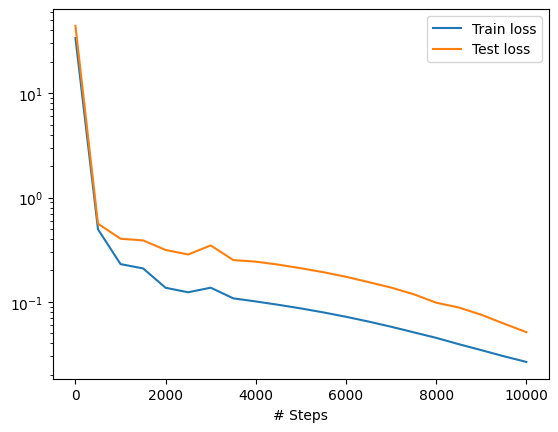

In [17]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [18]:
model2.compile("adam", lr=0.0001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model2.train(iterations=50000, display_every=1000, callbacks=callbacks)

Compiling model...
'compile' took 0.010159 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [4.13e-03, 8.76e-04, 3.33e-03, 5.22e-03, 5.16e-03, 4.13e-04, 7.47e-03]    [2.88e-02, 8.76e-04, 3.33e-03, 5.22e-03, 5.16e-03, 4.13e-04, 7.47e-03]    []  
10000 [1.37e+01]


W0000 00:00:1712519628.350901      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11000     [3.85e-03, 8.17e-04, 3.13e-03, 5.25e-03, 5.20e-03, 3.86e-04, 6.91e-03]    [2.71e-02, 8.17e-04, 3.13e-03, 5.25e-03, 5.20e-03, 3.86e-04, 6.91e-03]    []  
11000 [1.38e+01]
12000     [3.27e-03, 8.06e-04, 3.16e-03, 5.26e-03, 5.22e-03, 2.69e-04, 6.49e-03]    [2.32e-02, 8.06e-04, 3.16e-03, 5.26e-03, 5.22e-03, 2.69e-04, 6.49e-03]    []  
12000 [1.39e+01]
13000     [3.12e-03, 7.19e-04, 2.90e-03, 5.28e-03, 5.26e-03, 3.19e-04, 5.79e-03]    [2.22e-02, 7.19e-04, 2.90e-03, 5.28e-03, 5.26e-03, 3.19e-04, 5.79e-03]    []  
13000 [1.40e+01]
14000     [2.78e-03, 6.83e-04, 2.84e-03, 5.31e-03, 5.29e-03, 2.61e-04, 5.30e-03]    [1.98e-02, 6.83e-04, 2.84e-03, 5.31e-03, 5.29e-03, 2.61e-04, 5.30e-03]    []  
14000 [1.41e+01]
15000     [2.57e-03, 6.36e-04, 2.71e-03, 5.34e-03, 5.32e-03, 2.51e-04, 4.77e-03]    [1.84e-02, 6.36e-04, 2.71e-03, 5.34e-03, 5.32e-03, 2.51e-04, 4.77e-03]    []  
15000 [1.41e+01]
16000     [2.32e-03, 6.03e-04, 2.65e-03, 5.37e-03, 5.36e-03, 2.19e-04, 4.31e-03]    [1.66e-02, 6.03e

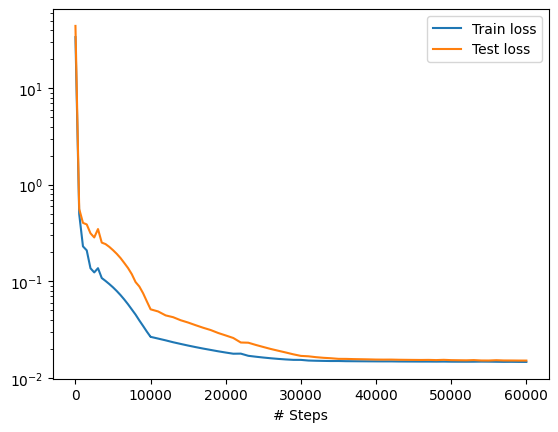

In [19]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [20]:
model2.compile("adam", lr=0.00001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model2.train(iterations=50000, display_every=1000, callbacks=callbacks)

Compiling model...
'compile' took 0.009169 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
60000     [2.25e-04, 3.83e-04, 2.20e-03, 5.82e-03, 5.84e-03, 1.30e-05, 1.58e-04]    [7.00e-04, 3.83e-04, 2.20e-03, 5.82e-03, 5.84e-03, 1.30e-05, 1.58e-04]    []  
60000 [1.58e+01]


W0000 00:00:1712521335.268063      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


61000     [2.24e-04, 3.84e-04, 2.20e-03, 5.81e-03, 5.84e-03, 1.26e-05, 1.58e-04]    [6.96e-04, 3.84e-04, 2.20e-03, 5.81e-03, 5.84e-03, 1.26e-05, 1.58e-04]    []  
61000 [1.58e+01]
62000     [2.25e-04, 3.85e-04, 2.19e-03, 5.81e-03, 5.84e-03, 1.32e-05, 1.58e-04]    [7.00e-04, 3.85e-04, 2.19e-03, 5.81e-03, 5.84e-03, 1.32e-05, 1.58e-04]    []  
62000 [1.58e+01]
63000     [2.23e-04, 3.87e-04, 2.20e-03, 5.81e-03, 5.83e-03, 1.25e-05, 1.58e-04]    [6.89e-04, 3.87e-04, 2.20e-03, 5.81e-03, 5.83e-03, 1.25e-05, 1.58e-04]    []  
63000 [1.58e+01]
64000     [2.22e-04, 3.89e-04, 2.20e-03, 5.80e-03, 5.83e-03, 1.21e-05, 1.58e-04]    [6.86e-04, 3.89e-04, 2.20e-03, 5.80e-03, 5.83e-03, 1.21e-05, 1.58e-04]    []  
64000 [1.58e+01]
65000     [2.22e-04, 3.91e-04, 2.20e-03, 5.80e-03, 5.82e-03, 1.21e-05, 1.57e-04]    [6.75e-04, 3.91e-04, 2.20e-03, 5.80e-03, 5.82e-03, 1.21e-05, 1.57e-04]    []  
65000 [1.58e+01]
66000     [2.20e-04, 3.93e-04, 2.20e-03, 5.79e-03, 5.82e-03, 1.08e-05, 1.58e-04]    [6.63e-04, 3.93e

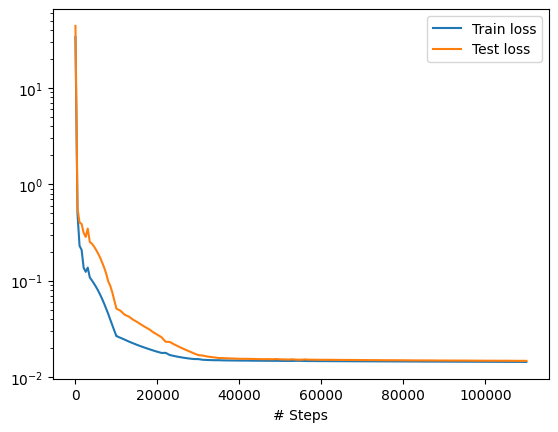

In [21]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [16]:
L = dde.Variable(20.0)
resample = dde.callbacks.PDEPointResampler(period=100, bc_points=False and dde.backend.backend_name == 'tensorflow')
variable = dde.callbacks.VariableValue(L, period=1000)
callbacks = [resample, variable]
layer_size = [3] + [30] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model3 = dde.Model(data, net)

In [17]:
model3.compile("adam", lr=0.001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model3.train(iterations=10000, display_every=500, callbacks=callbacks)

Compiling model...
'compile' took 0.006835 s

Training model...



I0000 00:00:1712562908.533725      34 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                Test loss                                                                 Test metric
0         [6.32e+01, 2.43e+00, 2.42e+00, 2.73e-01, 4.25e-01, 5.12e+00, 2.18e+00]    [1.05e+02, 2.43e+00, 2.42e+00, 2.73e-01, 4.25e-01, 5.12e+00, 2.18e+00]    []  
0 [2.00e+01]


W0000 00:00:1712562914.036550      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500       [1.97e-01, 2.06e-02, 1.40e-01, 2.85e-02, 2.95e-02, 1.49e-01, 4.25e-02]    [7.50e-01, 2.06e-02, 1.40e-01, 2.85e-02, 2.95e-02, 1.49e-01, 4.25e-02]    []  
1000      [5.66e-02, 4.70e-03, 7.21e-03, 1.34e-02, 1.26e-02, 1.75e-02, 2.64e-02]    [1.66e-01, 4.70e-03, 7.21e-03, 1.34e-02, 1.26e-02, 1.75e-02, 2.64e-02]    []  
1000 [1.99e+01]
1500      [3.00e-02, 3.35e-03, 5.18e-03, 1.21e-02, 1.09e-02, 1.75e-02, 2.63e-02]    [9.20e-02, 3.35e-03, 5.18e-03, 1.21e-02, 1.09e-02, 1.75e-02, 2.63e-02]    []  
2000      [2.15e-02, 3.01e-03, 4.68e-03, 1.16e-02, 1.06e-02, 1.75e-02, 2.58e-02]    [7.22e-02, 3.01e-03, 4.68e-03, 1.16e-02, 1.06e-02, 1.75e-02, 2.58e-02]    []  
2000 [1.98e+01]
2500      [1.81e-02, 2.81e-03, 4.11e-03, 1.13e-02, 1.05e-02, 1.68e-02, 2.51e-02]    [6.52e-02, 2.81e-03, 4.11e-03, 1.13e-02, 1.05e-02, 1.68e-02, 2.51e-02]    []  
3000      [1.58e-02, 2.65e-03, 3.85e-03, 1.11e-02, 1.04e-02, 1.55e-02, 2.42e-02]    [5.96e-02, 2.65e-03, 3.85e-03, 1.11e-02, 1.04e-02, 1.55e-02, 2.42e-02

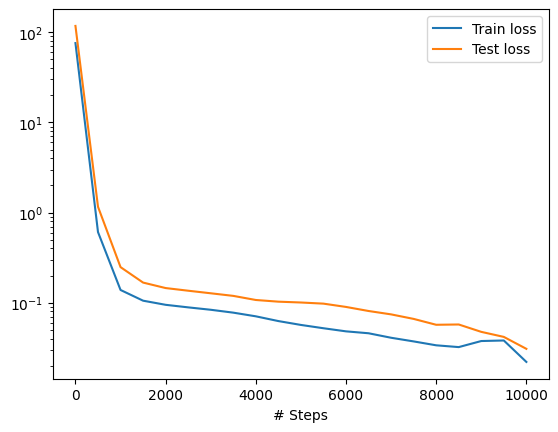

In [18]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [19]:
model3.compile("adam", lr=0.0001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model3.train(iterations=50000, display_every=1000, callbacks=callbacks)

Compiling model...
'compile' took 0.010800 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [1.85e-03, 5.11e-04, 2.58e-03, 7.32e-03, 7.14e-03, 2.19e-04, 2.40e-03]    [1.06e-02, 5.11e-04, 2.58e-03, 7.32e-03, 7.14e-03, 2.19e-04, 2.40e-03]    []  
10000 [1.74e+01]


W0000 00:00:1712563349.060629      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11000     [1.62e-03, 4.62e-04, 2.51e-03, 7.25e-03, 7.07e-03, 1.99e-04, 2.13e-03]    [9.09e-03, 4.62e-04, 2.51e-03, 7.25e-03, 7.07e-03, 1.99e-04, 2.13e-03]    []  
11000 [1.73e+01]
12000     [1.45e-03, 4.33e-04, 2.42e-03, 7.15e-03, 6.97e-03, 1.77e-04, 1.79e-03]    [8.04e-03, 4.33e-04, 2.42e-03, 7.15e-03, 6.97e-03, 1.77e-04, 1.79e-03]    []  
12000 [1.72e+01]
13000     [1.26e-03, 4.13e-04, 2.37e-03, 7.06e-03, 6.87e-03, 1.52e-04, 1.52e-03]    [6.95e-03, 4.13e-04, 2.37e-03, 7.06e-03, 6.87e-03, 1.52e-04, 1.52e-03]    []  
13000 [1.71e+01]
14000     [1.05e-03, 4.05e-04, 2.36e-03, 6.96e-03, 6.77e-03, 1.19e-04, 1.28e-03]    [5.69e-03, 4.05e-04, 2.36e-03, 6.96e-03, 6.77e-03, 1.19e-04, 1.28e-03]    []  
14000 [1.70e+01]
15000     [1.02e-03, 3.87e-04, 2.29e-03, 6.87e-03, 6.68e-03, 1.15e-04, 1.02e-03]    [5.32e-03, 3.87e-04, 2.29e-03, 6.87e-03, 6.68e-03, 1.15e-04, 1.02e-03]    []  
15000 [1.70e+01]
16000     [7.87e-04, 3.84e-04, 2.35e-03, 6.80e-03, 6.62e-03, 7.09e-05, 8.65e-04]    [3.73e-03, 3.84e

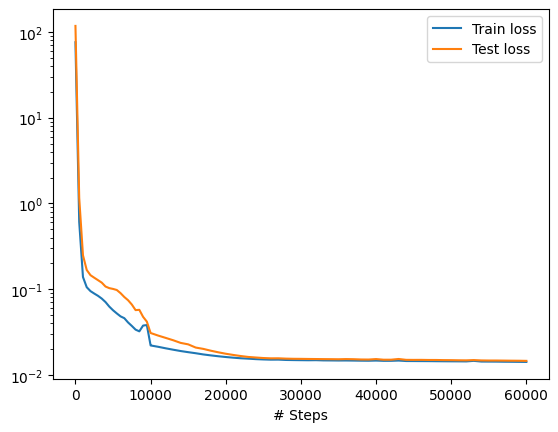

In [20]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [21]:
model3.compile("adam", lr=0.00001, loss = 'MSE', external_trainable_variables=L)
losshistory, train_state = model3.train(iterations=50000, display_every=1000, callbacks=callbacks)

Compiling model...
'compile' took 0.008162 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
60000     [2.59e-04, 4.65e-04, 2.21e-03, 5.68e-03, 5.39e-03, 1.96e-05, 1.26e-04]    [6.61e-04, 4.65e-04, 2.21e-03, 5.68e-03, 5.39e-03, 1.96e-05, 1.26e-04]    []  
60000 [1.59e+01]


W0000 00:00:1712565038.803471      34 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


61000     [2.56e-04, 4.69e-04, 2.21e-03, 5.67e-03, 5.39e-03, 1.93e-05, 1.22e-04]    [6.74e-04, 4.69e-04, 2.21e-03, 5.67e-03, 5.39e-03, 1.93e-05, 1.22e-04]    []  
61000 [1.59e+01]
62000     [2.55e-04, 4.76e-04, 2.21e-03, 5.66e-03, 5.37e-03, 1.88e-05, 1.22e-04]    [6.63e-04, 4.76e-04, 2.21e-03, 5.66e-03, 5.37e-03, 1.88e-05, 1.22e-04]    []  
62000 [1.59e+01]
63000     [2.56e-04, 4.77e-04, 2.21e-03, 5.65e-03, 5.35e-03, 1.93e-05, 1.23e-04]    [6.70e-04, 4.77e-04, 2.21e-03, 5.65e-03, 5.35e-03, 1.93e-05, 1.23e-04]    []  
63000 [1.59e+01]
64000     [2.55e-04, 4.83e-04, 2.21e-03, 5.63e-03, 5.33e-03, 1.86e-05, 1.23e-04]    [6.64e-04, 4.83e-04, 2.21e-03, 5.63e-03, 5.33e-03, 1.86e-05, 1.23e-04]    []  
64000 [1.59e+01]
65000     [2.60e-04, 4.85e-04, 2.21e-03, 5.62e-03, 5.31e-03, 1.86e-05, 1.25e-04]    [6.61e-04, 4.85e-04, 2.21e-03, 5.62e-03, 5.31e-03, 1.86e-05, 1.25e-04]    []  
65000 [1.59e+01]
66000     [2.56e-04, 4.97e-04, 2.22e-03, 5.60e-03, 5.29e-03, 1.74e-05, 1.23e-04]    [6.36e-04, 4.97e

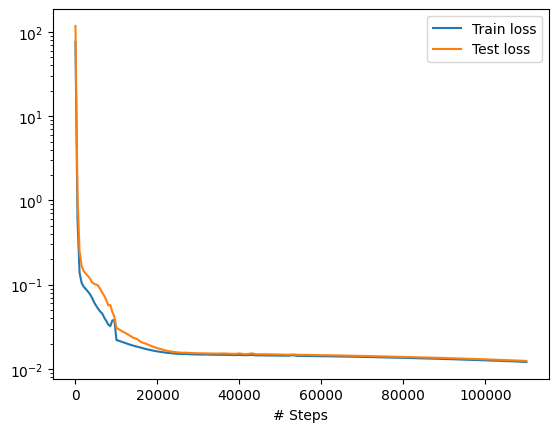

In [22]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)